In [1]:
# setup
import sys
import subprocess
import re
import os
import spacy
import numpy as np
import pandas as pd
import transformers

from bs4 import BeautifulSoup
from spacy.lang.en import English

nlp = spacy.load('en_core_web_md')

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#Importuojame paketus
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importuojame duomenis

In [2]:
# Fake and real news Kaggle dataset
kaggle_data = pd.read_csv('data/kaggle/combined.csv', sep=";")

# Get rid of unnecessary data
kaggle_data.drop(columns=['subject'], inplace=True)

kaggle_data.head()

label                                              title  \
0      1   Donald Trump Sends Out Embarrassing New Year’...   
1      1   Drunk Bragging Trump Staffer Started Russian ...   
2      1   Sheriff David Clarke Becomes An Internet Joke...   
3      1   Trump Is So Obsessed He Even Has Obama’s Name...   
4      1   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  
0  Donald Trump just couldn t wish all Americans ...  
1  House Intelligence Committee Chairman Devin Nu...  
2  On Friday, it was revealed that former Milwauk...  
3  On Christmas day, Donald Trump announced that ...  
4  Pope Francis used his annual Christmas Day mes...

In [3]:
# WELFake dataset (will need to select a subset, since it's huge)
wellfake_data = pd.read_csv('data/welfake/data.csv', sep=';', encoding_errors='ignore')

wellfake_data.head()

title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                NaN   
2  UNBELIEVABLE! OBAMAS ATTORNEY GENERAL SAYS MOS...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1

In [5]:
# Proppy dataset (will need to drop real news to to balance dataset (undersample?))
proppy_dev = pd.read_csv('data/proppy/data-dev.csv',  sep=';', encoding_errors='ignore')
proppy_test = pd.read_csv('data/proppy/data-test.csv',  sep=';', encoding_errors='ignore')
proppy_train = pd.read_csv('data/proppy/data-train.csv',  sep=';', encoding_errors='ignore')

proppy_data = pd.concat([proppy_dev, proppy_test, proppy_train], ignore_index=True, sort=False)

# Get rid of unnecessary data
proppy_data.drop(columns=['source'], inplace=True)

# Change label from -1 to 0, to match others 
proppy_data['label'].mask(proppy_data['label'] == -1.0, 0, inplace=True)

# Rename columns 
proppy_data.rename(columns={"article_text": "text", "headline": "title"}, inplace=True)

proppy_data.head()

text  \
0  Convened to examine the causes of civil unrest...   
1  Discriminating against someone on the basis of...   
2  Bill Cosby's 44-year-old daughter, Ensa Cosby,...   
3  The fast-moving, powerful theatrical locomotiv...   
4  It's Friday. It's National Pizza Day. Grab lif...   

                                               title  label  
0  Report: No progress for African-Americans on h...    0.0  
1  Employers can't discriminate based on sexual o...    0.0  
2  Bill Cosby's daughter Ensa, 44, dies in Massac...    0.0  
3  'Murder On The Orient Express' A Funny, Fast-P...    0.0  
4    You Can Celebrate National Pizza Day Right Here    0.0

#### Clean data

In [6]:
# Remove duplicates
print("Kaggle data dupe num", kaggle_data.duplicated().sum())
kaggle_data.drop_duplicates(inplace = True)

print("WellFake data dupe num", wellfake_data.duplicated().sum())
wellfake_data.drop_duplicates(inplace = True)

print("Proppy data dupe num", proppy_data.duplicated().sum())
proppy_data.drop_duplicates(inplace = True)

# Drop invalid rows (containing NaN/Empty values)
print("\nKaggle null values\n", kaggle_data.isnull().sum())
kaggle_data.dropna(inplace = True)

print("Wellfake null values\n", wellfake_data.isnull().sum())
wellfake_data.dropna(inplace=True)

print("Proppy null value rows\n", proppy_data.isnull().sum())
proppy_data.dropna(inplace=True)


Kaggle data dupe num 0
WellFake data dupe num 0
Proppy data dupe num 0

Kaggle null values
 label    0
title    1
text     5
dtype: int64
Wellfake null values
 title    518
text      39
label      0
dtype: int64
Proppy null value rows
 text     2
title    7
label    7
dtype: int64


##### Because Wellfake includes kaggle data, we need to remove overlapping objects

In [7]:
wellfake_new_data = wellfake_data.drop_duplicates().merge(kaggle_data.drop_duplicates(), on=kaggle_data.columns.to_list(), 
                   how='left', indicator=True)
wellfake_data = wellfake_new_data.loc[wellfake_new_data._merge=='left_only',wellfake_new_data.columns!='_merge']
len(wellfake_data)


45476

### Duomenų rinkinių analizė 

##### Klasių pasiskirstymas (WellFake)

21071
24405


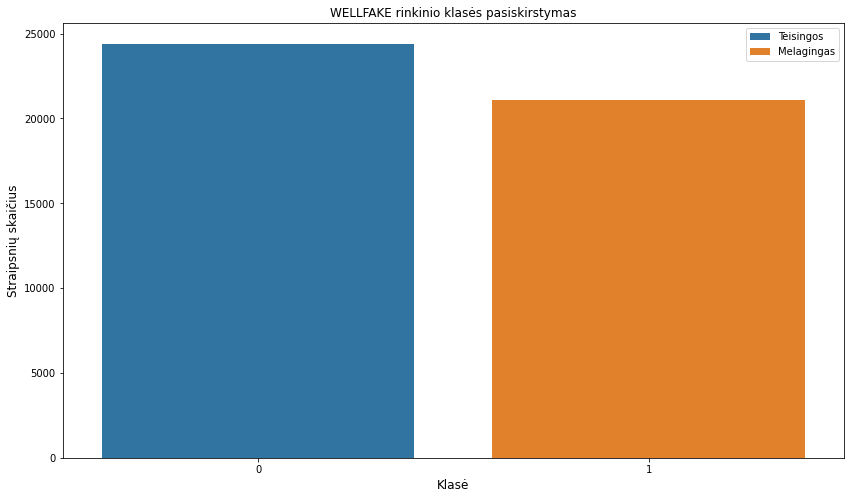

45476

In [41]:
plt.figure(figsize=(14,8))
sns.countplot(x='label', hue="label",dodge=False, data=wellfake_data)
plt.title('WELLFAKE rinkinio klasės pasiskirstymas')
plt.ylabel('Straipsnių skaičius', fontsize=12)
plt.xlabel('Klasė', fontsize=12)
plt.legend(['Teisingos', 'Melagingas'], loc="upper right")

df_fake = wellfake_data[wellfake_data['label']==1.0]
df_real = wellfake_data[wellfake_data['label']==0.0]

print(len(df_fake))
print(len(df_real))

plt.show()
len(wellfake_data)

##### Klasių pasiskirstymas (Kaggle)

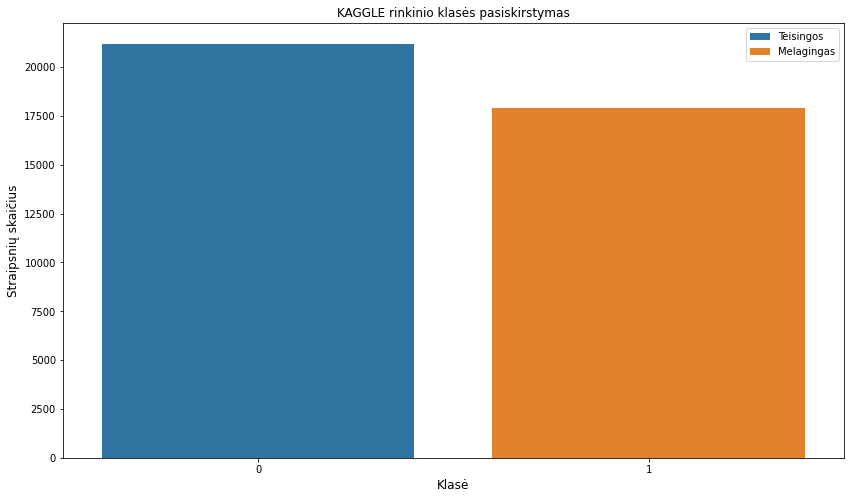

39105

In [42]:
plt.figure(figsize=(14,8))
sns.countplot(x='label', hue="label",dodge=False, data=kaggle_data)
plt.title('KAGGLE rinkinio klasės pasiskirstymas')
plt.ylabel('Straipsnių skaičius', fontsize=12)
plt.xlabel('Klasė', fontsize=12)
plt.legend(['Teisingos', 'Melagingas'], loc="upper right")

df_fake = kaggle_data[kaggle_data['label']==1.0]
df_real = kaggle_data[kaggle_data['label']==0.0]


plt.show()
len(kaggle_data)

##### Klasių pasiskirstymas (Proppy)

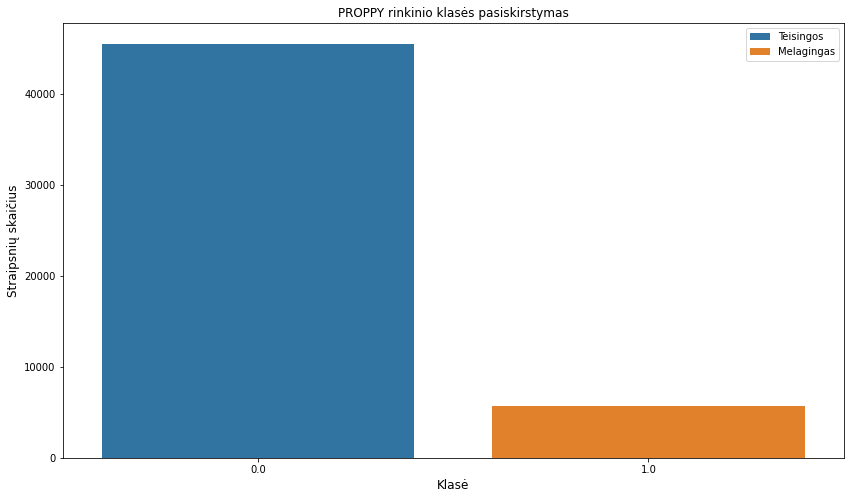

51285
5736


45549

In [43]:
plt.figure(figsize=(14,8))
sns.countplot(x='label', hue="label",dodge=False, data=proppy_data)
plt.title('PROPPY rinkinio klasės pasiskirstymas')
plt.ylabel('Straipsnių skaičius', fontsize=12)
plt.xlabel('Klasė', fontsize=12)
plt.legend(['Teisingos', 'Melagingas'], loc="upper right")

plt.show()
df_fake = proppy_data[proppy_data['label']==1.0]
df_real = proppy_data[proppy_data['label']==0.0]

print(len(proppy_data))
print(len(df_fake))
len(df_real)


#### Kaggle

### Pravalome teksta

In [118]:
def lowercase(text):
    return text.lower()

# removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# remove urls
def remove_url(text):
    return re.sub(r'http\S+', '', text)

# remove inbetween brackets
def remove_punctuation(text):
    return re.sub('[^\w\s]', '', text)

# Removal of Special Characters
def remove_numbers(text):
    return re.sub('\d', '', text)

# Removal of stopwords
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word)
            final_text.append(word)
    return final_text

def clean_text(text):
    text = lowercase(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

In [115]:
# KAGGLE
# cleaning primary text
print(kaggle_data['text'][0])
print("\n")
print(clean_text(kaggle_data['text'][0]))
# cleaning title
print("\n")
print(kaggle_data['title'][5])
print(clean_text(kaggle_data['title'][5]))

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

In [119]:
# WELLFAKE
# cleaning primary text
print(wellfake_data['text'][6])
print("\n")
print(clean_text(wellfake_data['text'][6]))
# cleaning title
print("\n")
print(wellfake_data['title'][2])
print(clean_text(wellfake_data['title'][2]))

FILE  In this Sept. 15, 2005 file photo, the marker that welcomes commuters to Cushing, Okla. is seen. (AP Photo/The Oklahoman, Matt Strasen, File)
Underscoring once again the dangers of Americas unreliable fossil fuel infrastructure, a significant U.S. oil pipeline has been shut down after a leak was reported Monday morning.
Enterprise Products Partners said Monday it had shut its Seaway Crude Pipeline, a 400,000-barrel per day conduit that transports crude oil from Cushing, Oklahoma to Gulf coast refineries. The leak occurred Sunday night in an industrial area of Cushing. The company did not provide an estimate of the volume spilled, but said there was no danger to the public.
Seaway personnel continue to make progress in cleaning up the spill, substantially all of which has been contained in a retention pond at Enbridges facility, the company said in a news release (pdf), explaining that the pipeline is a 50/50 joint venture between Enterprise and Enbridge Inc. Vacuum trucks are bei

In [51]:
# PROPPY
# cleaning primary text
print(proppy_data['text'][0])
print("\n")
print(clean_text(proppy_data['text'][0]))
# cleaning title
print("\n")
print(proppy_data['title'][0])
print(clean_text(proppy_data['title'][0]))

Convened to examine the causes of civil unrest in black communities, the presidential commission issued a 1968 report with a stark conclusion: America was moving towards two societies, "one black, one white — separate and unequal."  Fifty years after the historic Kerner Commission identified "white racism" as the key cause of "pervasive discrimination in employment, education and housing," there has been no progress in how African-Americans fare in comparison to whites when it comes to homeownership, unemployment and incarceration, according to a report by the Economic Policy Institute released Monday.  In some cases, African-Americans are worse off today than they were before the civil rights movement culminated in laws barring housing and voter discrimination as well as racial segregation.  7.5 percent of African-Americans were unemployed in 2017, compared to 6.7 percent in 1968 — still roughly twice the white unemployment rate.  The rate of homeownership, one of the most important w

In [52]:
kaggle_data['cleaned_text']=kaggle_data['text'].apply(clean_text)
kaggle_data['cleaned_title']=kaggle_data['title'].apply(clean_text)

c:\Python39\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
c:\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Python39\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [53]:
wellfake_data['cleaned_text']=wellfake_data['text'].apply(clean_text)
wellfake_data['cleaned_title']=wellfake_data['title'].apply(clean_text)

c:\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Python39\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
c:\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Python39\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [54]:
proppy_data['cleaned_text']=proppy_data['text'].apply(clean_text)
proppy_data['cleaned_title']=proppy_data['title'].apply(clean_text)

c:\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


### Dazniausiai naudojami zodziai pagal klasę

In [65]:
def plot_wordcloud(df, attribute):
  plt.figure(figsize = (15,15))
  wc = WordCloud(max_words = 50 , width = 300 , height = 300 , stopwords = STOPWORDS).generate(" ".join(df[attribute]))
  plt.imshow(wc , interpolation = 'bilinear') 

def plot_real_and_fake_for(df, attribute):
  print("Most common words in fake news")
  df_pos = df.loc[df['label'] == 1.0]
  plot_wordcloud(df_pos, attribute)
  # Real news
  print("Most common words in real news")
  df_neg = df.loc[df['label'] == 0.0]
  plot_wordcloud(df_neg, attribute)

#### Kaggle

Most common words in fake news
Most common words in real news


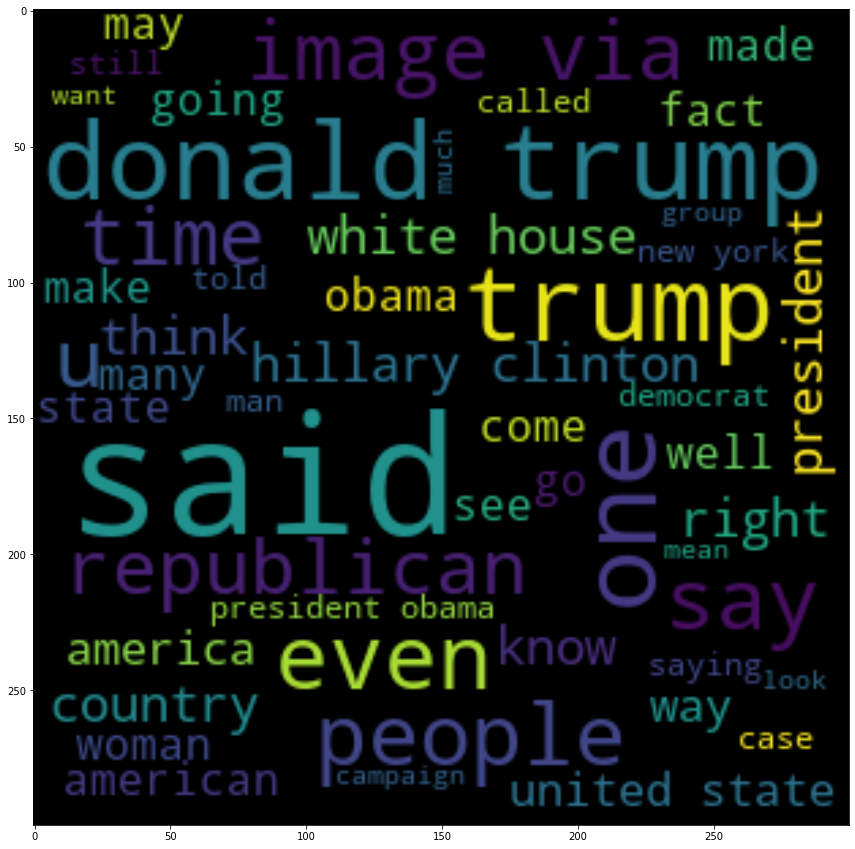

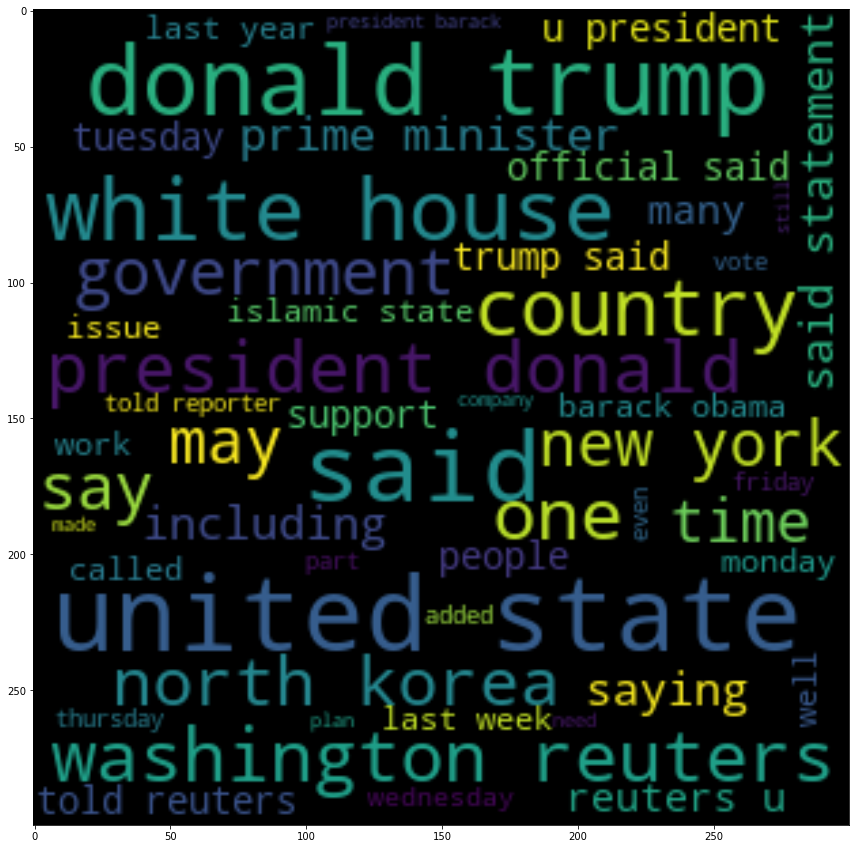

In [66]:
plot_real_and_fake_for(kaggle_data, 'cleaned_text')

Most common words in fake news
Most common words in real news


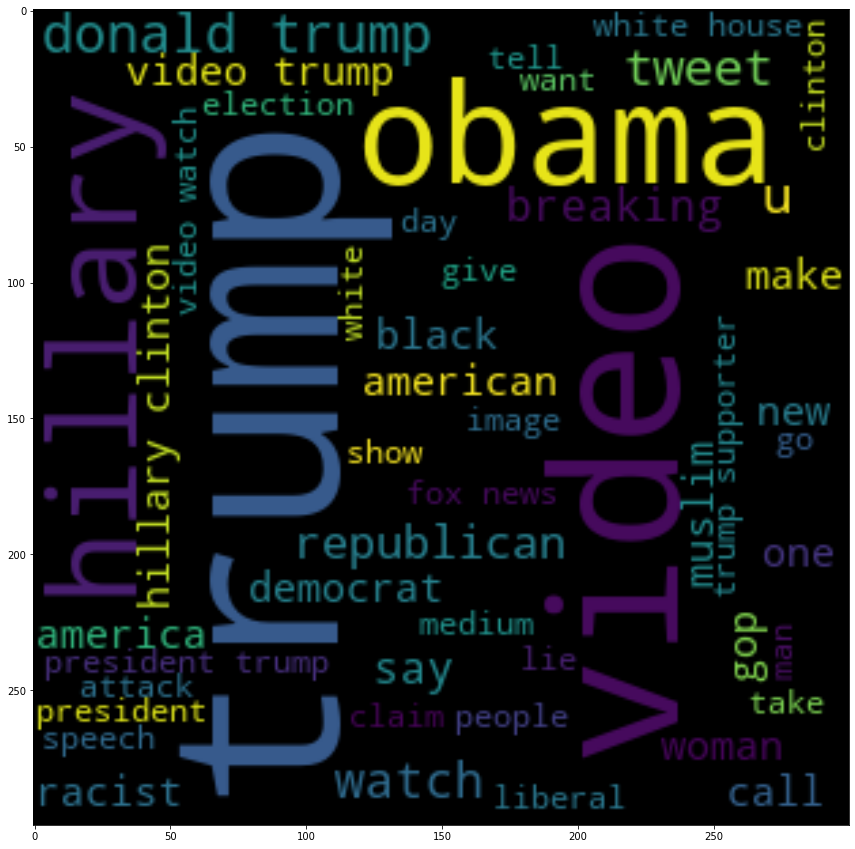

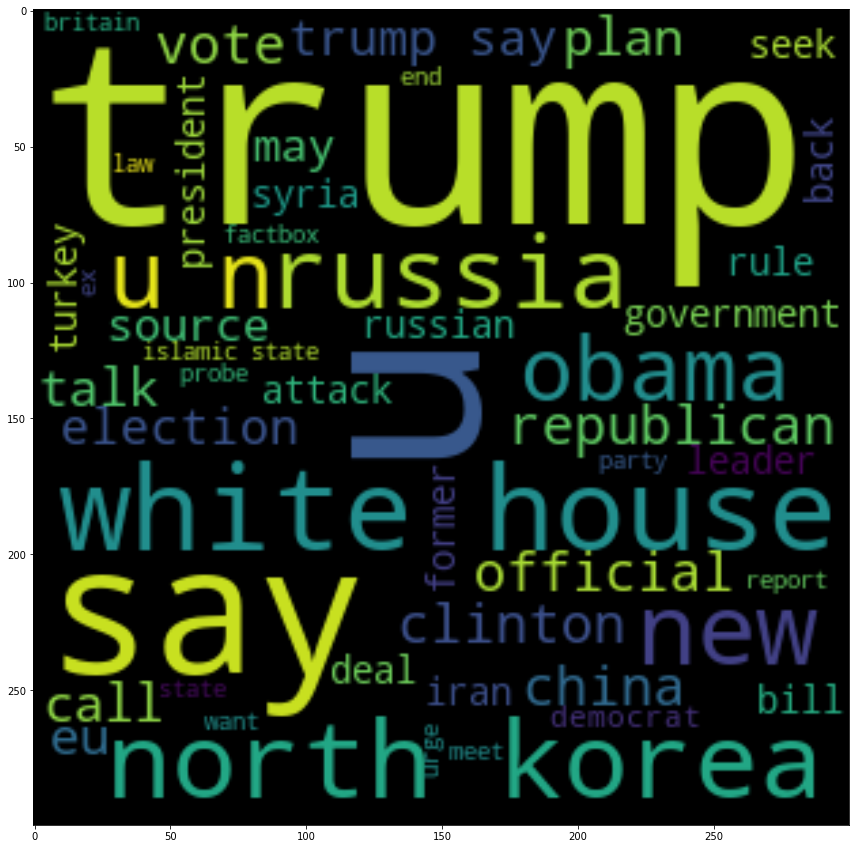

In [ ]:
plot_real_and_fake_for(kaggle_data, 'cleaned_title')

### proppy

Most common words in fake news
Most common words in real news


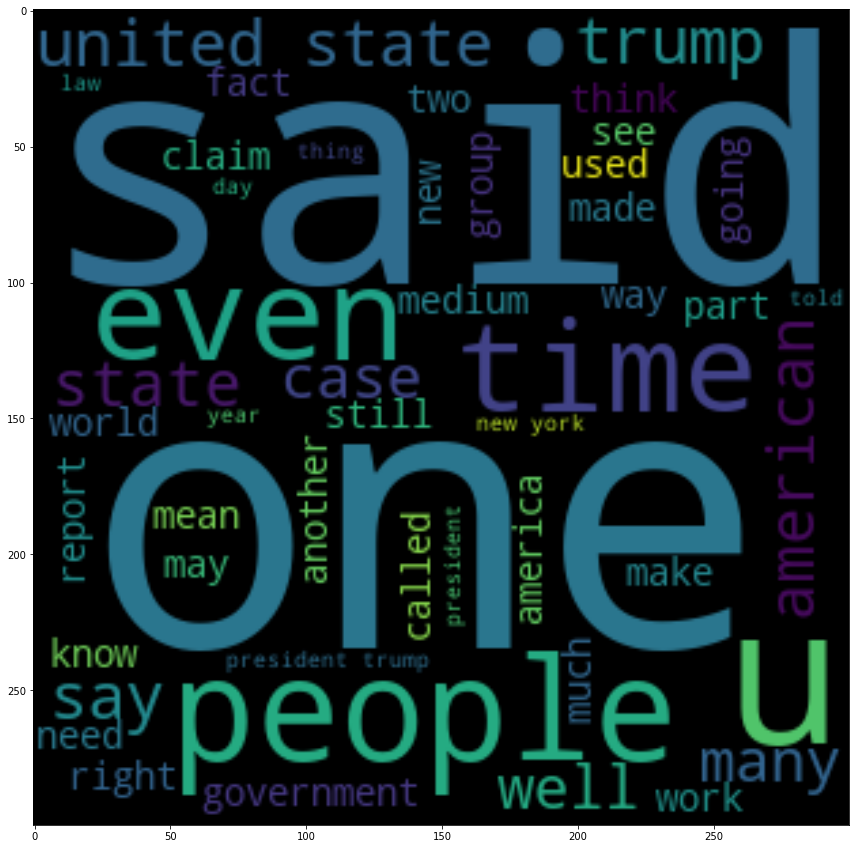

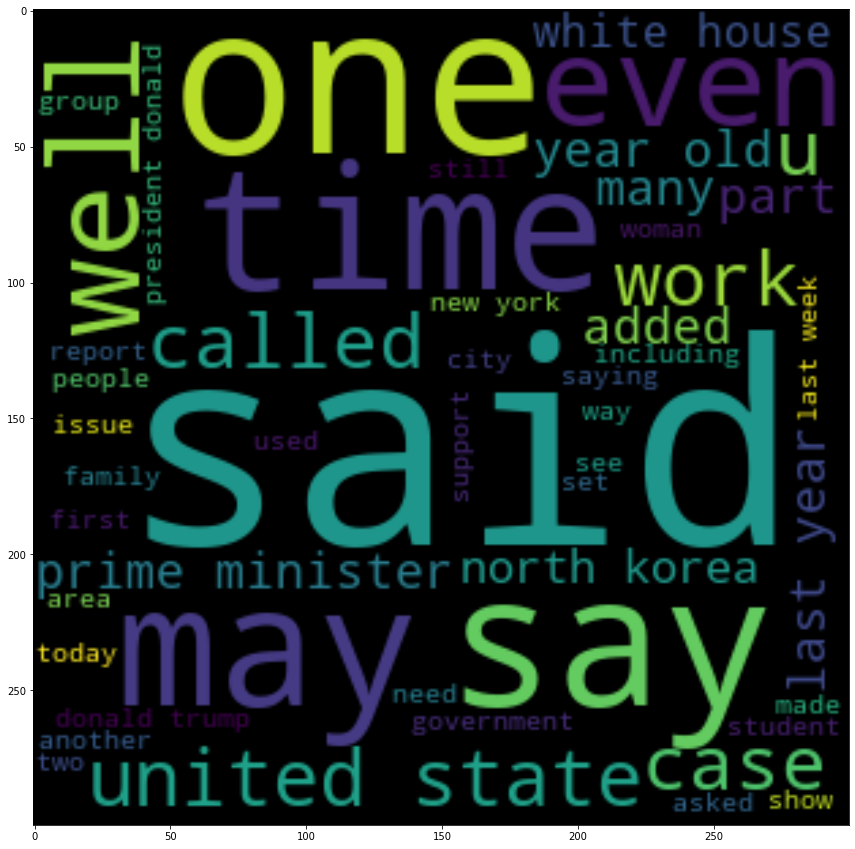

In [ ]:
plot_real_and_fake_for(proppy_data, 'cleaned_text')

Most common words in fake news
Most common words in real news


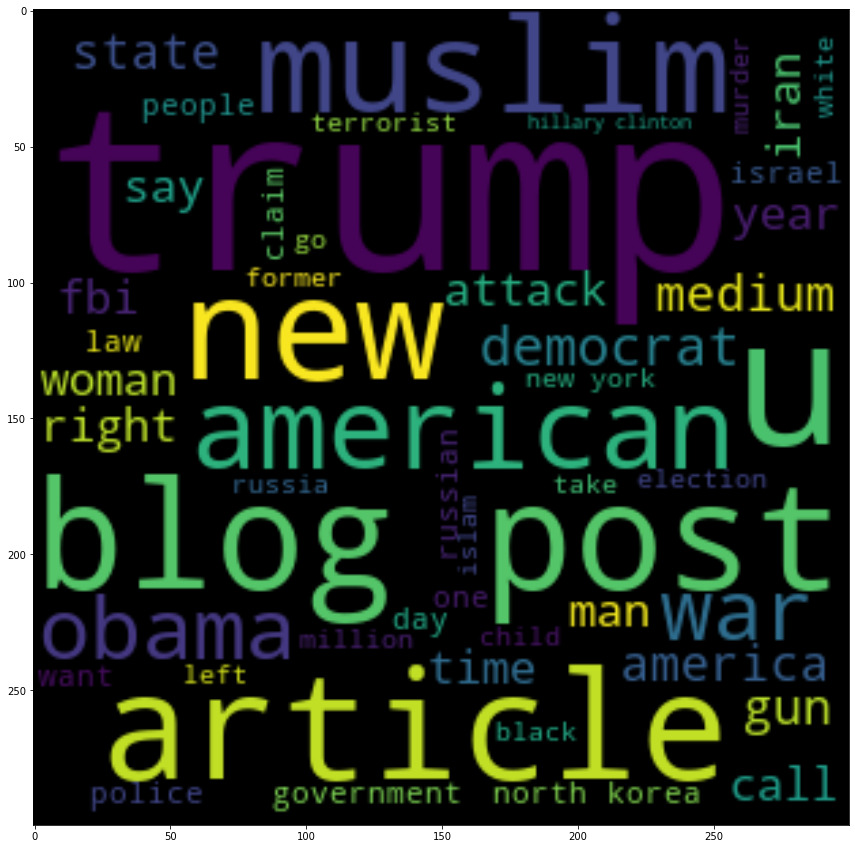

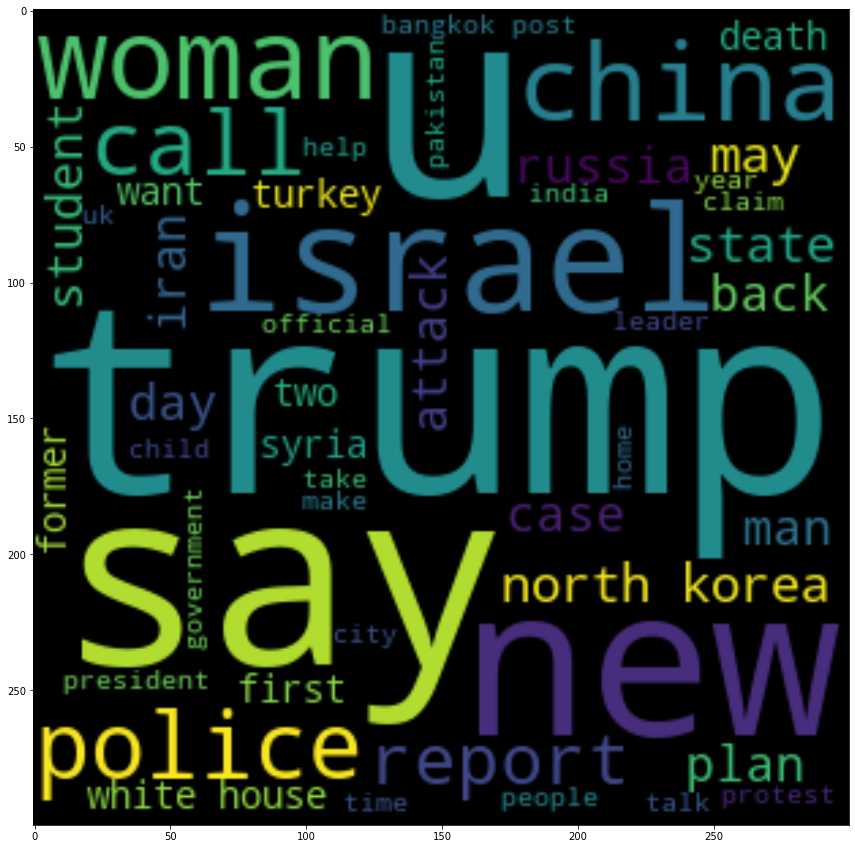

In [ ]:
plot_real_and_fake_for(proppy_data, 'cleaned_title')

### wellfake

Most common words in fake news
Most common words in real news


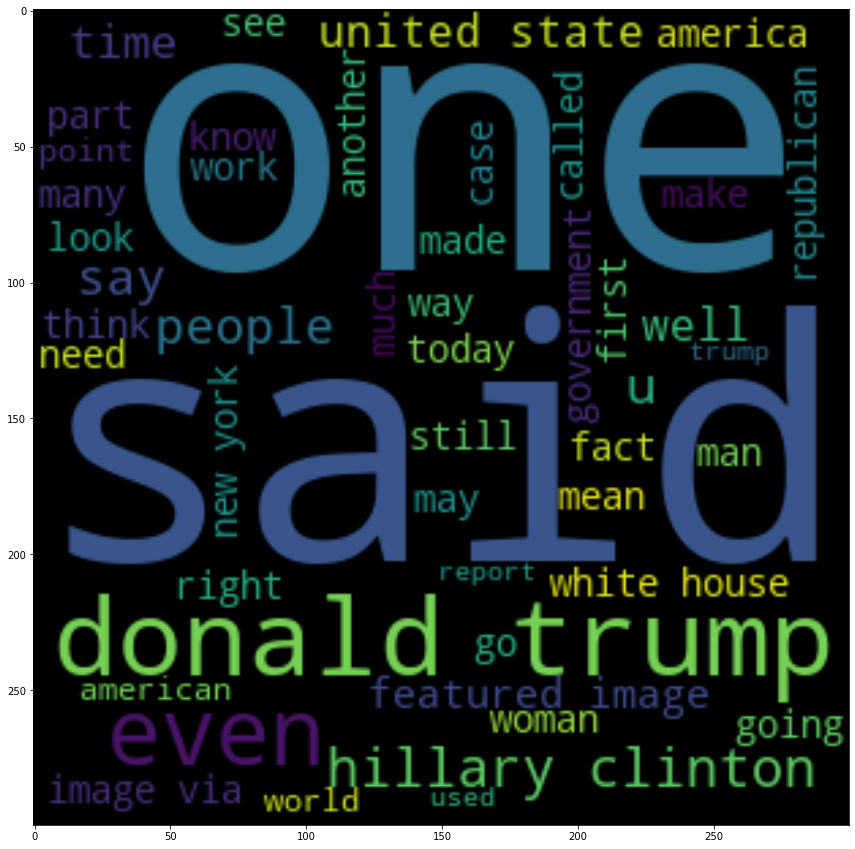

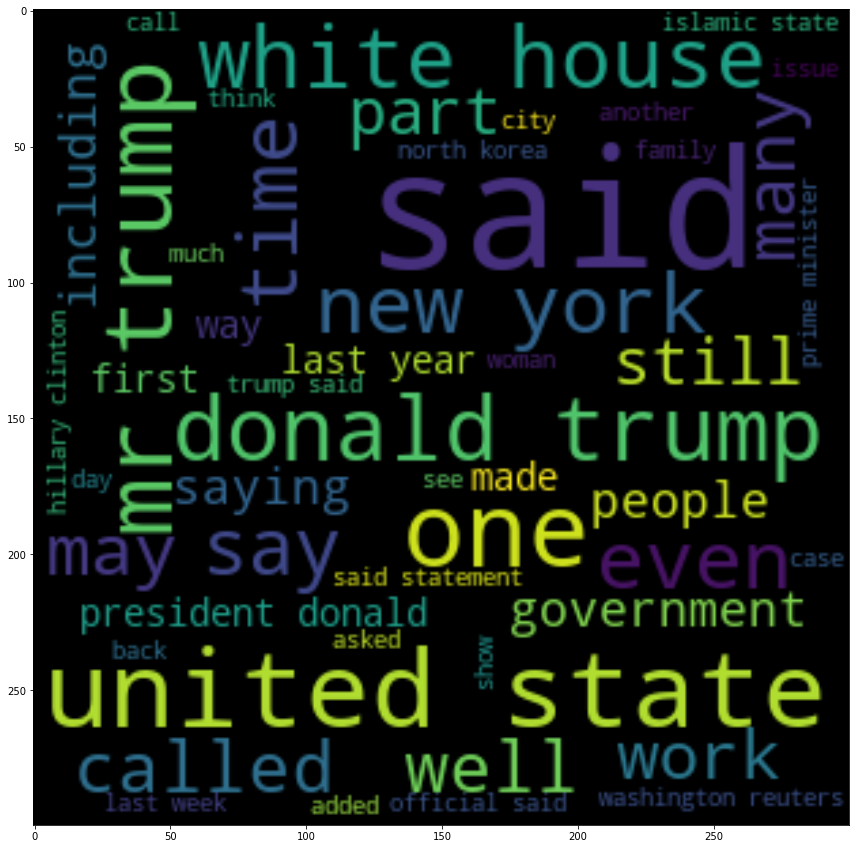

In [ ]:
plot_real_and_fake_for(wellfake_data, 'cleaned_text')

Most common words in fake news
Most common words in real news


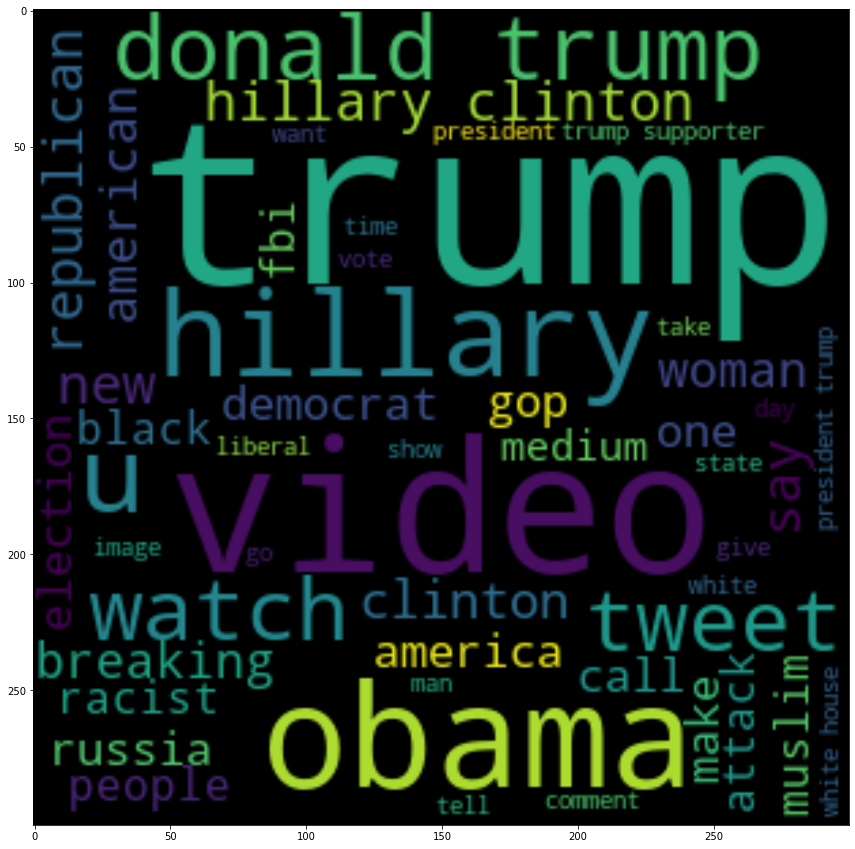

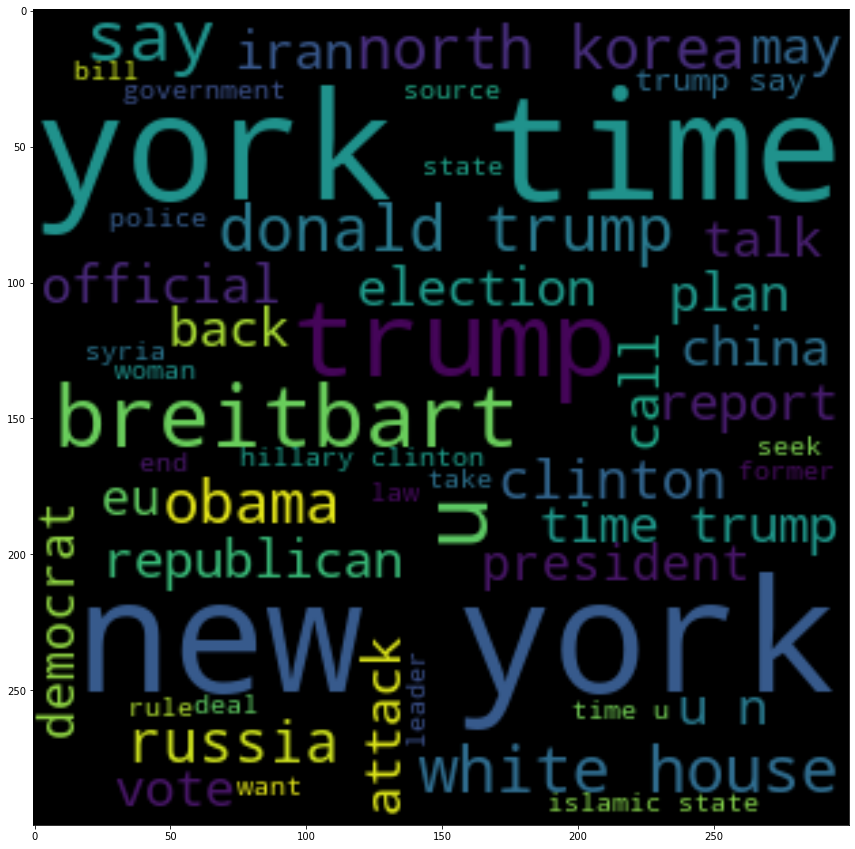

In [ ]:
plot_real_and_fake_for(wellfake_data, 'cleaned_title')

## Vidutinis žodžių skaičius kiekviename tipe

In [10]:
def word_count_plot(df, col='cleaned_text'):
    # Set the style to grayscale
    sns.set(style='white', palette='gray')

    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot histogram for fake news
    text_len_fake = df[df['label'] == 0][col].str.split().map(lambda x: len(x))
    ax1.hist(text_len_fake, color='lightgray', edgecolor='black')
    ax1.set_title('Fake News')
    ax1.set_xlabel('Word Count')
    ax1.set_ylabel('Frequency')

    for i in ax1.patches:
        ax1.text(i.get_x() + i.get_width() / 2, i.get_height(), str(int(i.get_height())), ha='center', va='bottom')

    # Plot histogram for real news
    text_len_real = df[df['label'] == 1][col].str.split().map(lambda x: len(x))
    ax2.hist(text_len_real, color='lightgray', edgecolor='black')
    ax2.set_title('Real News')
    ax2.set_xlabel('Word Count')
    ax2.set_ylabel('Frequency')

    for i in ax2.patches:
        ax2.text(i.get_x() + i.get_width() / 2, i.get_height(), str(int(i.get_height())), ha='center', va='bottom')

    # Set the title
    fig.suptitle(f'Words in {col}', fontsize=16, fontweight='bold')

    # Remove spines
    sns.despine()

    # Display the plot
    plt.tight_layout()
    plt.show()


#### Kaggle

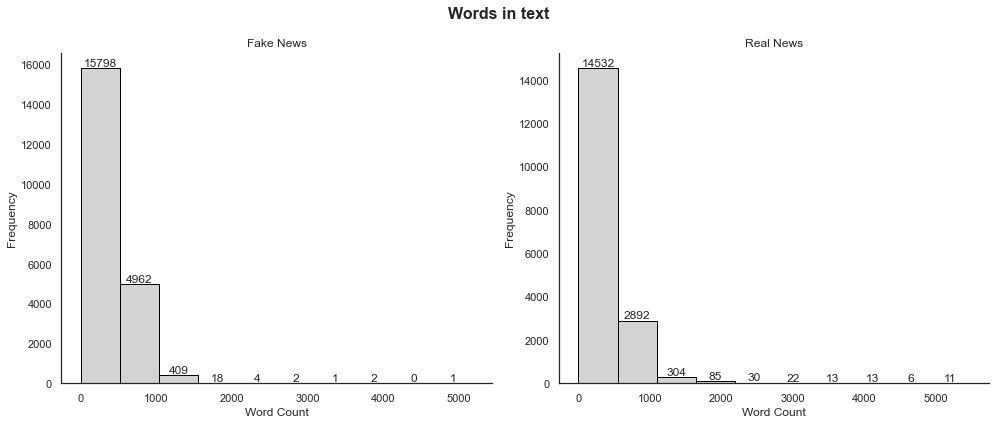

In [11]:
word_count_plot(kaggle_data, 'text')
# word_count_plot(kaggle_data, 'cleaned_title')

#### Proppy

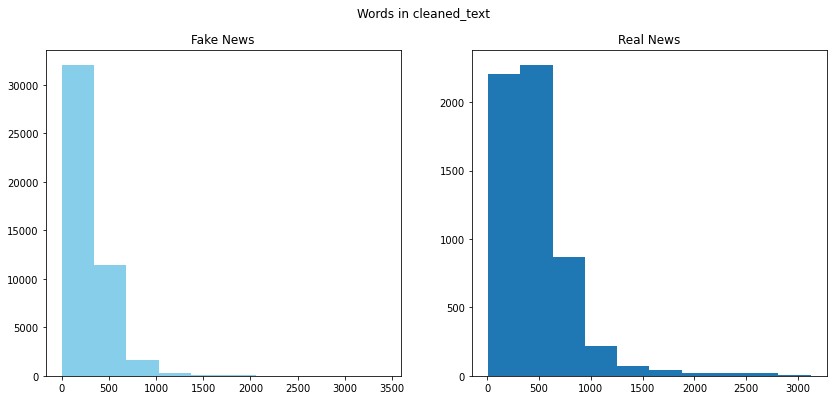

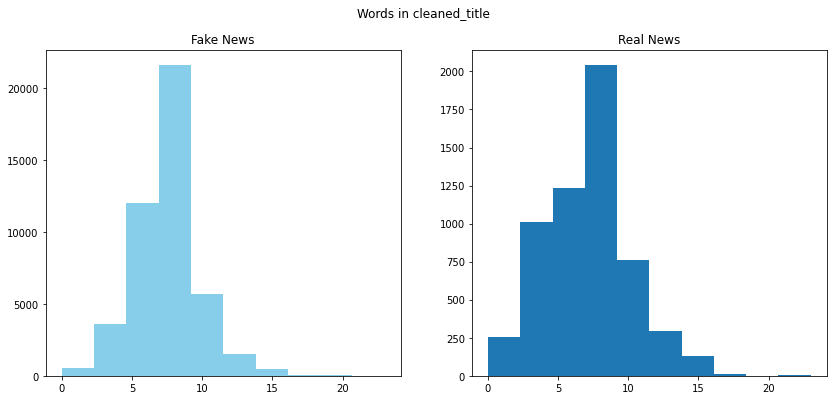

In [ ]:
word_count_plot(proppy_data, 'cleaned_text')
word_count_plot(proppy_data, 'cleaned_title')

#### Wellfake

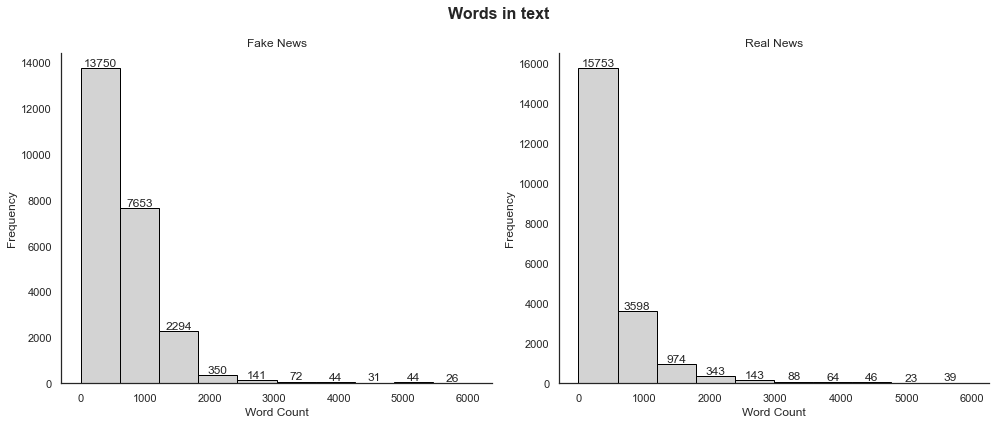

In [12]:
word_count_plot(wellfake_data, 'text')
# word_count_plot(wellfake_data, 'cleaned_title')
